# Libs

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Standart task 2.0

### Class

In [15]:
class FullyConnectedFitForwardNetwork:

    def __net_input(self,X,layer):
        return X.dot(self.W[layer]) + self.B[layer]
    
    def forward_pass(self,A):
        for layer in range(1,self.depth_ + 1):
            Z = self.__net_input(A,layer)
            A = self.activate_layer(Z,layer)
        return A
    
    def activate_layer(self,Z,layer):
        return self.activation_functions[layer](Z)

    def cost(self,X,y,regularization_rate):
        p = self.forward_pass(X)
        cross_entropy = -((y*np.log(p)) + (1-y)*np.log(1-p)).sum()
        l2_cost = 0
        for layer in range(1,self.depth_+1):
            l2_cost += (self.W[layer] ** 2).sum()
        l2_cost = - l2_cost * regularization_rate
        return cross_entropy + l2_cost
    
    def forward_pass_g(self,A,W,B):
        for layer in range(1,self.depth_ + 1):
            Z = A.dot(W[layer])+ B[layer]
            A = self.activate_layer(Z,layer)
        return A
    
    def cost_g(self,X,y,regularization_rate,TETA):
        W,B = TETA
        p = self.forward_pass_g(X,W,B)
        cross_entropy = -((y*np.log(p)) + (1-y)*np.log(1-p)).sum()
        l2_cost = 0
        for layer in range(1,self.depth_+1):
            l2_cost += (self.W[layer] ** 2).sum()
        l2_cost = - l2_cost * regularization_rate
        return cross_entropy + l2_cost
    
    def grad_check(self,X,y,l2_rate,dW,dB):
        TETA = [self.W.copy()] + [self.B.copy()]
        D_TETA = [dW] + [dB]
        deriv_num_TETA = []
        deriv_TETA = []
        for d,dd in zip(TETA,D_TETA):
            for layer in range(1,self.depth_+1):
                n,m = d[layer].shape
                for i in range(n):
                    for j in range(m):
                        tmp = d[layer][i,j]
                        d[layer][i,j] = tmp - 10e-7
                        c1 = self.cost_g(X,y,l2_rate,TETA)
                        d[layer][i,j] = tmp + 10e-7
                        c2 = self.cost_g(X,y,l2_rate,TETA)
                        deriv_num_TETA.append((c1-c2)/(2.0*10e-7))
                        d[layer][i,j] = tmp 
                        deriv_TETA.append(dd[layer][i,j])
        deriv_num_TETA = np.array(deriv_num_TETA)
        deriv_TETA = np.array(deriv_TETA)
        error = self.l2_norm(deriv_num_TETA - deriv_TETA)/(self.l2_norm(deriv_num_TETA) + self.l2_norm(deriv_TETA))
        return error < 10e-7
    def l2_norm(self,X):
        return (np.sum(X)**2)**0.5
    
    def __split_mini_batch(self,X,y,batch_count):
        n,_ = X.shape
        rX,ry = shuffle(X,y)
        if batch_count > n:
            batch_count = n
        rx = np.array_split(rX,batch_count)
        ry = np.array_split(ry,batch_count)
        return zip(rx,ry)
        
    def backward_pass(self,X,y,learning_rate,hidden_neurons,functions,max_iter,batch_count,eps = 0.01,l2_rate = 0.0):
        self.activation_functions = functions
        _,m = X.shape
        neurons = [m] + hidden_neurons + [1]
        self.W = {}; self.B = {}
        W = self.W; B = self.B
        for layer in range(1,len(neurons)):
            W[layer] = np.random.normal(scale = 0.01,size = (neurons[layer-1],neurons[layer]))
            B[layer] = np.random.normal(scale = 0.01,size = (1,neurons[layer]))
        A = {}; Z = {}; dA = {}; dZ = {}; dW = {}; db = {}
        self.depth_ = len(neurons) - 1; L = self.depth_
        it = 0; self.costs = []
        current_cost = self.cost(X,y,l2_rate)
        while True:
            prev_cost = current_cost
            mini_batches = self.__split_mini_batch(X,y,batch_count)
            for X_b,y_b in mini_batches:
                # Step 1 - forward pass
                A[0] = X_b
                for layer in range(1,self.depth_ + 1):
                    Z[layer] = self.__net_input(A[layer-1],layer)
                    A[layer] = self.activate_layer(Z[layer],layer)
                # Step 2 - backward pass
                dA[L] = ((1.0 - y_b)/(1.0 - A[L]) - y_b/A[L])
                dZ[L] = dA[L] * functions[L](Z[L],True)
                dW[L] = (A[L - 1].T).dot(dZ[L]) + l2_rate *(W[L]**2)
                db[L] = np.mean(dZ[L],axis=0,keepdims = True)
                for layer in range(self.depth_-1,0,-1):
                    # 2.a 
                    dA[layer] = dZ[layer + 1].dot(W[layer + 1].T)
                    dZ[layer] = dA[layer] * functions[layer](Z[layer],True)
                    # 2.b
                    dW[layer] = (A[layer - 1].T).dot(dZ[layer]) + l2_rate *(W[layer]**2)
                    #dW[layer] = ((dZ[layer].T).dot(A[layer-1])).T
                    db[layer] = np.mean(dZ[layer],axis=0,keepdims = True)
                    # Step 3
                for layer in range(1,self.depth_+1):
                    W[layer] -= learning_rate * dW[layer]
                    B[layer] -= learning_rate * db[layer]
            it += 1
            if it == max_iter:
                break
            self.costs.append(self.cost(X,y,l2_rate))
            ceps = current_cost - prev_cost
            #if abs(ceps) < eps:
            #    break
        self.it = it
        return self

### NN function

In [16]:
def sigmoid(Z,deriv = False):
    if deriv:
        s = sigmoid(Z)
        return s*(1-s)
    s = 1.0/(1.0 + np.exp(-1.0 * Z))
    np.minimum(s, 1.0 - np.finfo(np.float64).eps,out = s)
    np.maximum(s, np.finfo(np.float64).eps,out = s)
    return s

def relu(Z, deriv = False):
    if deriv:
        return np.where(Z > 0, 1, 0)
    return np.where(Z > 0, Z, 0)

### GLOBALS

In [17]:
n_samples = 2000

### 1) XOR

##### 1.1) Generate XOR

In [18]:
samples_per_corner = int(n_samples/4)
y = np.array([1]*(2*samples_per_corner) + [0]*(2*samples_per_corner))

In [19]:
# left buttom
x1 = np.random.normal(3,1,samples_per_corner)
x2 = np.random.normal(3,1,samples_per_corner)
# right top
x1 = np.concatenate((x1, np.random.normal(9,1,samples_per_corner)), axis=None)
x2 = np.concatenate((x2, np.random.normal(9,1,samples_per_corner)), axis=None)

In [20]:
# right buttom
x1 = np.concatenate((x1, np.random.normal(9,1,samples_per_corner)), axis=None)
x2 = np.concatenate((x2, np.random.normal(3,1,samples_per_corner)), axis=None)
# left top
x1 = np.concatenate((x1, np.random.normal(3,1,samples_per_corner)), axis=None)
x2 = np.concatenate((x2, np.random.normal(9,1,samples_per_corner)), axis=None)

##### 1.2) data preparation

In [21]:
y = y.reshape(-1,1)
X = np.stack((x1,x2),axis=0).T
X,y = shuffle(X,y)

##### 1.3) Training

In [22]:
hidden_neurons = [4]
activations_f = {1:relu,2:sigmoid}

In [84]:
max_iter = 30
learning_rate = 0.01
l2_rate = 0.001

In [85]:
nn = FullyConnectedFitForwardNetwork()
np.random.seed(1)
nn.backward_pass(X,y,learning_rate,hidden_neurons,activations_f,max_iter,400,l2_rate=l2_rate);
print('iterations =', max_iter)
print('learning rate =', learning_rate)

iterations = 30
learning rate = 0.01


##### 1.4) Predic

In [86]:
y_pred = np.where(nn.forward_pass(X) > 0.5,1,0).ravel()
print('accuracy =',accuracy_score(y,y_pred))

accuracy = 0.97


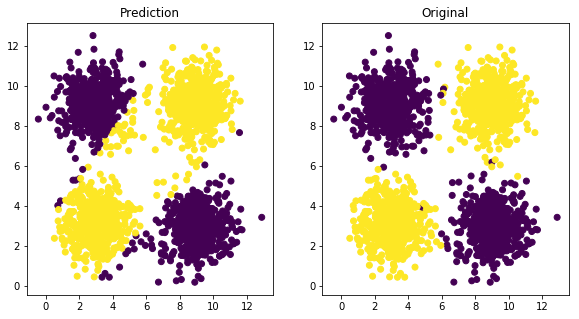

In [87]:
plt.figure(figsize=(15,5))
plt.subplot(131).set_title('Prediction')
plt.scatter(X[:,0],X[:,1],c=np.where(y_pred>0.5,1,0))
plt.subplot(132).set_title('Original')
plt.scatter(X[:,0],X[:,1],c=y.ravel())
plt.show()

##### 1.5) Cost

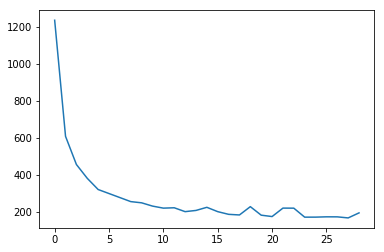

In [88]:
plt.plot(range(len(nn.costs)),nn.costs,'-')
plt.show()

### 2) Circles

##### 2.1) Generate circles

In [112]:
X, y = make_circles(n_samples=n_samples,factor=.5, noise=.05)

##### 2.2) Data preparation

In [113]:
y_true = y.reshape(-1,1)
X_std = X

##### 2.3) Training

In [114]:
hidden_neurons = [4,2]
activations_f = {1:relu,2:relu,3:sigmoid}

In [120]:
max_iter = 50
learning_rate = 0.03

In [121]:
nn = FullyConnectedFitForwardNetwork()
np.random.seed(1)
nn.backward_pass(X_std,y_true,learning_rate,hidden_neurons,activations_f,max_iter,75);
print('iterations =', max_iter)
print('learning rate =', learning_rate)

iterations = 50
learning rate = 0.03


##### 2.4) Predict

In [122]:
y_pred = np.where(nn.forward_pass(X_std) > 0.5,1,0).ravel()
print('accuracy =',accuracy_score(y_true,y_pred))

accuracy = 1.0


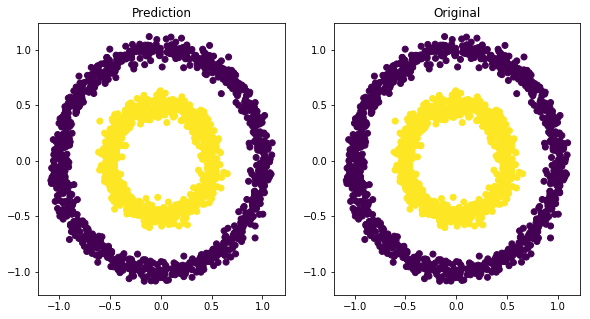

In [123]:
plt.figure(figsize=(15,5))
plt.subplot(131).set_title('Prediction')
plt.scatter(X_std[:,0],X_std[:,1],c=y_pred)
plt.subplot(132).set_title('Original')
plt.scatter(X_std[:,0],X_std[:,1],c=y_true.ravel())
plt.show()

##### 2.5) Cost

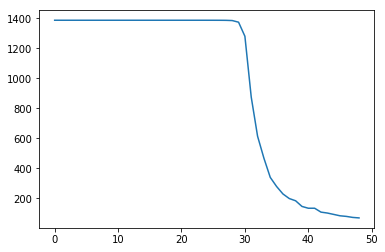

In [124]:
plt.plot(range(len(nn.costs)),nn.costs,'-')
plt.show()

### 3) Moons

##### 3.1) Generate moons

In [125]:
X, y = make_moons(n_samples=n_samples, noise=.1,shuffle=True)

##### 3.2) Data preparation

In [126]:
y_true = y.reshape(-1,1)
X_std = X

##### 3.3) Training

In [133]:
hidden_neurons = [4,2]
activations_f = {1:relu,2:relu,3:sigmoid}

In [194]:
max_iter = 55
learning_rate = 0.025
l2_rate = 0.005

In [195]:
nn = FullyConnectedFitForwardNetwork()
np.random.seed(1)
nn.backward_pass(X_std,y_true,learning_rate,hidden_neurons,activations_f,max_iter,75,l2_rate=l2_rate);
print('iterations =', max_iter)
print('learning rate =', learning_rate)
print('l2 rate =', l2_rate)

iterations = 55
learning rate = 0.025
l2 rate = 0.03


##### 3.4) Predict

In [196]:
y_pred = np.where(nn.forward_pass(X_std) > 0.5,1,0).ravel()
print('accuracy =',accuracy_score(y_true,y_pred))

accuracy = 0.997


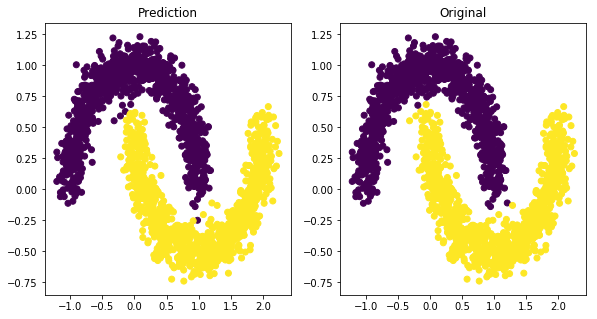

In [197]:
plt.figure(figsize=(15,5))
plt.subplot(131).set_title('Prediction')
plt.scatter(X_std[:,0],X_std[:,1],c=y_pred.ravel())
plt.subplot(132).set_title('Original')
plt.scatter(X_std[:,0],X_std[:,1],c=y_true.ravel())
plt.show()

In [198]:
a = np.array([[1],[2]])

##### 3.5) Cost

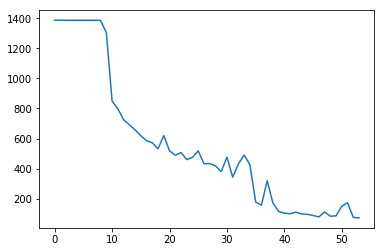

In [199]:
plt.plot(range(len(nn.costs)),nn.costs,'-')
plt.show()

# Task - Heart

## Data preparation

Features information
------------------------------
      -- 1. age       
      -- 2. sex       
      -- 3. chest pain type  (4 values)       
      -- 4. resting blood pressure  
      -- 5. serum cholestoral in mg/dl      
      -- 6. fasting blood sugar > 120 mg/dl       
      -- 7. resting electrocardiographic results  (values 0,1,2) 
      -- 8. maximum heart rate achieved  
      -- 9. exercise induced angina    
      -- 10. oldpeak = ST depression induced by exercise relative to rest   
      -- 11. the slope of the peak exercise ST segment     
      -- 12. number of major vessels (0-3) colored by flourosopy        
      -- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

Variable to be predicted
---------------------------------
Absence (1) or presence (2) of heart disease

Cost Matrix

	     abse  pres
absence	 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   0 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1<br>
presence &nbsp;&nbsp;&nbsp;&nbsp;   5 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;	0

In [202]:
features = ['1','2','3','4','5','6','7','8','9','10','11','12','13','y']

In [203]:
real = ['1','4','5','8','10','12']
ordered = ['11']
binary = ['2','6','9']
nominal = ['7','3','13']

In [204]:
def preprocess(df):
    df['y'] = df['y'].replace({1:0,2:1})
    df = pd.get_dummies(df,columns = nominal,drop_first = True)
    df[real] = StandardScaler().fit_transform(df[real].values)
    df[ordered] = MinMaxScaler().fit_transform(df[ordered].values)
    return df

In [205]:
df = preprocess(pd.read_csv('data/heart.csv',sep = ' ', header = None,names = features))

In [206]:
df.head(3)

,1,2,4,5,6,8,9,10,11,12,y,7_1.0,7_2.0,3_2.0,3_3.0,3_4.0,13_6.0,13_7.0
0,1.712094,1.0,-0.075410,1.402212,0.0,-1.759208,0.0,1.181012,0.5,2.472682,1,0,1,0,0,1,0,0
1,1.382140,0.0,-0.916759,6.093004,0.0,0.446409,0.0,0.481153,0.5,-0.711535,0,0,1,0,1,0,0,1
2,0.282294,1.0,-0.411950,0.219823,0.0,-0.375291,0.0,-0.656118,0.0,-0.711535,1,0,0,1,0,0,0,1


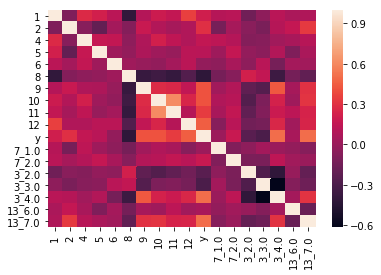

In [207]:
sns.heatmap(df.corr())
plt.show()

## Train,Tets split

In [210]:
X = df[df.columns.difference(['y'])].values
y = df['y'].values.reshape(-1,1)

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle = True)

## Training

In [213]:
nn = FullyConnectedFitForwardNetwork()

In [234]:
hidden_neurons = [4,2]
activations_f = {1:relu,2:relu,3:sigmoid}
max_iter = 65
learning_rate = 0.01
l2_rate = 0.0

In [235]:
np.random.seed(1)
nn.backward_pass(X_std,y_true,learning_rate,hidden_neurons,activations_f,max_iter,75,l2_rate=l2_rate);
print('iterations =', max_iter)
print('learning rate =', learning_rate)
print('l2 rate =', l2_rate)

iterations = 65
learning rate = 0.01
l2 rate = 0.0


In [236]:
y_pred = np.where(nn.forward_pass(X_std) > 0.5,1,0).ravel()
print('accuracy =',accuracy_score(y_true,y_pred))

accuracy = 0.979


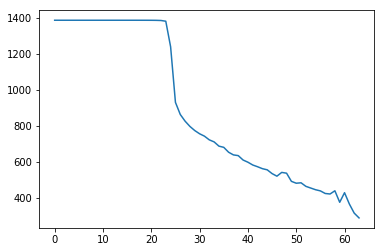

In [237]:
plt.plot(range(len(nn.costs)),nn.costs,'-')
plt.show()